In [1]:
import numpy as np 
import nevis 

h = nevis.gb()

area = np.load('../res/area-with-sea.npy')
label = np.load('../res/label.npy')
maxima = np.load('../res/maxima.npy')
path_sum = np.load('../res/path_sum.npy')

expected_fe = path_sum / area

- `maxima` = [($x_0, y_0$), ... ], where $(x_i, y_i)$ is the grid coordinate of the $i$-th hill, sorted from the highest to the lowest. The length of maxima is the number of hills = number of basin of attraction.
- `label[x][y]` means grid coordinate $(x, y)$ belongs to the $i$-th basin of attraction (which belongs to the $i$-th hill).
- `area[i]` returns the area of the $i$-th basin of attraction (including sea).
- `path_sum[i]` returns the sum of (gradient ascending) path lengths from each point to the $i$-th local max in the $i$-th b.o.a. 
- `path_sum[i] / area[i]` is the average path length (function evaluation) from each point in the $i$-th b.o.a to the $i$-th local max.

In [2]:
# check that the sum of areas add up
m, n = nevis.dimensions()
assert int(np.sum(area)) == m * n // 2500

In [3]:
# check that the i-th local max belongs to the i-th b.o.a.
len_maxima = len(maxima)
for i in range(len_maxima):
    assert i == label[maxima[i, 0], maxima[i, 1]]

In [4]:
# a two-line tour to ben nevis
x, y = maxima[0]
h[x-1:x+2, y-1:y+2]

array([[1343.1, 1342.1, 1340.9],
       [1339.6, 1345.3, 1343.8],
       [1222.5, 1299.1, 1327.7]], dtype=float32)

### Why are there local maxima below sea level?

In [5]:
sea_max_height_list = []
# iterate through all local max and find those under sea levels
for i in range(len_maxima):
    x, y = maxima[i]
    z = h[x, y]
    if z < 0:
        sea_max_height_list.append((x, y, z))

In [6]:
# the total number of such local max
len(sea_max_height_list)

6631

(array([4.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 7.000e+00, 6.000e+00,
        2.000e+00, 1.000e+00, 7.400e+01, 6.534e+03]),
 array([-20.80000305, -18.73000336, -16.66000175, -14.59000206,
        -12.52000141, -10.45000076,  -8.38000011,  -6.30999994,
         -4.23999929,  -2.16999888,  -0.09999847]),
 <BarContainer object of 10 artists>)

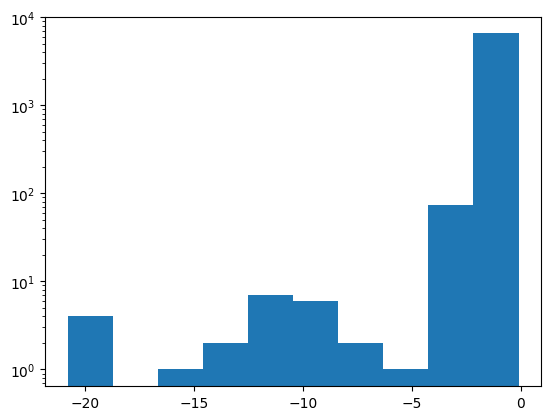

In [7]:
# the distribution of height of such local max
zs = [p[2] for p in sea_max_height_list]
import matplotlib.pyplot as plt
plt.hist(zs, log=True)

In [8]:
# some numerical results
intervals = [(-0.1, 0), (-0.2, -0.1), (-1, -0.2), (-2, -1), (-5, -2), (-10, -5), (-30, -10)]
for i, j in intervals:
    print(
        f'[{i}, {j})',
        len(list(filter(lambda x: i <= x < j, zs)))
    )

[-0.1, 0) 1
[-0.2, -0.1) 800
[-1, -0.2) 3972
[-2, -1) 1722
[-5, -2) 114
[-10, -5) 7
[-30, -10) 15


In [9]:
# print the surrounding of some samples
for i in [-30, -20, -10, -5, -2, -1, -0.2, -0.1]:
    for x, y, z in sea_max_height_list:
        if z < i:
            print(f"x, y, z = {x}, {y}, {z}")
            print(h[x-2:x+3, y-2:y+3])
            break

x, y, z = 6302, 9120, -20.099998474121094
[[ 14.4        -2.1       -57.2       -81.2        -6.9000015]
 [  3.2       -42.9       -91.3       -21.300003  -48.600006 ]
 [  1.        -85.9       -20.099998  -49.100006  -49.800003 ]
 [  1.9       -88.        -34.600006  -49.100006  -49.199997 ]
 [ 16.        -82.5       -20.800003  -48.699997  -49.399994 ]]
x, y, z = 5957, 10491, -10.199999809265137
[[-12.8 -12.9 -12.8 -12.9 -14.5]
 [-12.6 -12.7 -13.2 -13.8 -14.4]
 [-10.  -10.9 -10.2 -10.3 -12.5]
 [-15.8 -16.1 -15.8 -16.4 -15.9]
 [-16.4 -16.1 -16.  -16.3 -16.4]]
x, y, z = 5929, 9025, -6.6999969482421875
[[-31.199997 -11.599998 -80.9      -32.7       38.7     ]
 [-22.800003 -33.399994 -97.5      -58.4        1.9     ]
 [-95.8      -33.600006  -6.699997 -76.       -23.5     ]
 [-73.       -30.699997 -25.5      -91.3      -42.2     ]
 [-43.1       -9.900002 -33.899994 -91.1      -64.9     ]]
x, y, z = 5607, 11196, -2.0999999046325684
[[-2.2 -2.1 -2.1 -2.2 -2.2]
 [-2.2 -2.1 -2.1 -2.2 -2.2]
 

1. Some of these points are classified as a local maximum because they have the same height as all of their neighbours (let's call them **flat local maxima** for now). 
2. But there are also points which are clearly higher than its neighbours.

Discussion. Is this classification in (1) justifiable? If a point has the same height as all of its neighbours, then the gradient ascending method indeed should converge to it, but this point is not a 'hill' in the usual sense (even if it's not underwater). On the other hand, does this happen very frequently on the land where the heights tend to vary?

What can we do? Can we change this classficiation (1)? We could report the number of such points among the local maxima.

Why does (2) happen? **I don't know**.

### Are there a lot of 'flat local maxima'?

**UPDATE**: as we adopted the new algorithm for calculating local maxima, we have eliminated all 'flat local maxima'. 

In [10]:
neighbours = [
    (-1, 0), (1, 0), (0, -1), (0, 1),
    (-1, -1), (-1, 1), (1, 1), (1, -1),
]
eps = 1e-5
m, n = h.shape
flat_local_max = []
for i in range(len_maxima):
    x, y = maxima[i]
    flat = True
    for dx, dy in neighbours:
        sx, sy = x + dx, y + dy
        if not (0 <= sx < m and 0 <= sy < n):
            continue
        if abs(h[sx, sy] - h[x, y]) > eps:
            flat = False
            break
    if flat: 
        flat_local_max.append((x, y, h[x, y]))

In [11]:
len(flat_local_max)

0

OK actually there are quite a few of those flat local maxima! What about their distrubtion in heights?

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

/home/eric/projects/EricSummer2022/venv/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


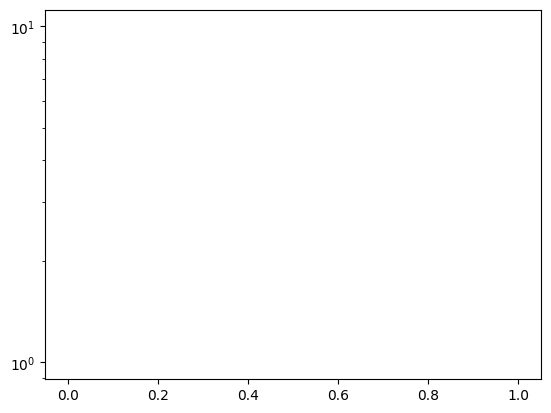

In [12]:
zs = [p[2] for p in flat_local_max]
plt.hist(zs, log=True)

Again let's print some samples:

In [13]:
flat_local_max.sort(key=lambda p: p[2])
for i in [-20, -10, -1, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900]:
    for x, y, z in flat_local_max:
        if z > i:
            print(f"x, y, z = {x}, {y}, {z}")
            print(h[x-2:x+3, y-2:y+3])
            break

Question. Do we want to report this number (530415 flat local max) to distinguish them from those places that are strictly higher than at one of its neighbours?

Another question is how many **strict local maxima** there are, defined as a point that is strictly higher than *all* of its neighbours?

### What about strict local maxima?

In [14]:
neighbours = [
    (-1, 0), (1, 0), (0, -1), (0, 1),
    (-1, -1), (-1, 1), (1, 1), (1, -1),
]
eps = 1e-5
m, n = h.shape
strict_local_max = []
for i in range(len_maxima):
    x, y = maxima[i]
    strict = True
    for dx, dy in neighbours:
        sx, sy = x + dx, y + dy
        if not (0 <= sx < m and 0 <= sy < n):
            continue
        if not abs(h[sx, sy] - h[x, y]) > eps:
            strict = False
            break
    if strict: 
        strict_local_max.append((x, y, h[x, y]))

In [15]:
len(strict_local_max)

868312

This is the number of 'hills' (a place that is higher than all of its adjacent places) in the ususal sense. Again we print out the height distribution and some samples.

(array([5.86628e+05, 1.69302e+05, 6.30600e+04, 2.95750e+04, 1.13310e+04,
        5.10700e+03, 2.34000e+03, 7.36000e+02, 1.98000e+02, 3.50000e+01]),
 array([ -20.80000305,  115.81000519,  252.42001343,  389.02999878,
         525.64001465,  662.25      ,  798.86004639,  935.47003174,
        1072.08007812, 1208.69006348, 1345.30004883]),
 <BarContainer object of 10 artists>)

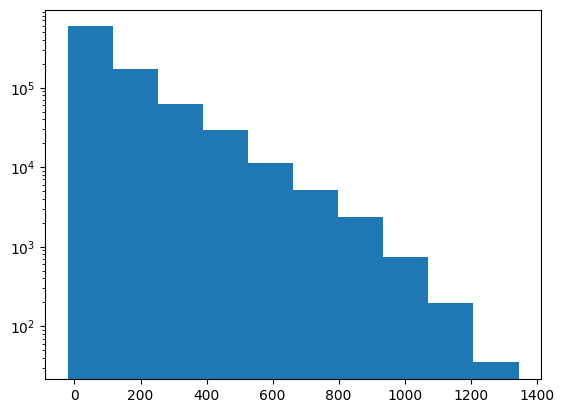

In [16]:
zs = [p[2] for p in strict_local_max]
plt.hist(zs, log=True)

In [17]:
strict_local_max.sort(key=lambda p: p[2])
for i in [-20, -10, -1, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900,
          1000, 1100, 1200, 1300]:
    for x, y, z in strict_local_max:
        if z > i:
            print(f"x, y, z = {x}, {y}, {z}")
            print(h[x-2:x+3, y-2:y+3])
            break

x, y, z = 5937, 10468, -19.100000381469727
[[-20.7 -19.8 -19.8 -20.9 -10.1]
 [-21.1 -20.3 -19.3 -22.2 -19. ]
 [-20.6 -19.7 -19.1 -21.6 -21.6]
 [-20.5 -20.3 -21.8 -21.  -21. ]
 [-21.4 -20.5 -19.8 -19.3 -19.9]]
x, y, z = 5931, 9024, -9.900001525878906
[[-66.9      -95.8      -33.600006  -6.699997 -76.      ]
 [-34.2      -73.       -30.699997 -25.5      -91.3     ]
 [-15.3      -43.1       -9.900002 -33.899994 -91.1     ]
 [  6.7      -39.2      -77.2      -33.300003 -11.900002]
 [ 25.6      -14.6      -52.3      -16.699997 -25.699997]]
x, y, z = 5365, 11073, -0.8999999761581421
[[-0.9 -1.4 -1.5 -1.3 -1. ]
 [-0.7 -1.  -1.2 -1.2 -1.2]
 [-1.  -1.5 -0.9 -1.1 -1.1]
 [-1.1 -1.2 -1.1 -1.  -0.8]
 [-1.1 -1.3 -1.1 -1.  -0.6]]
x, y, z = 1753, 7879, 0.10000000149011612
[[-0.04000854 -0.03000641 -0.02000427 -0.02000427 -0.01000214]
 [-0.03000641 -0.02000427 -0.01000214 -0.02000427 -0.02000427]
 [-0.02000427 -0.01000214  0.1        -0.01000214 -0.02000427]
 [-0.03000641 -0.02000427 -0.01000214 -0.020